# Diffraction with detector noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from SimExLite.DetectorCalculators import GaussianNoiseCalculator
from SimExLite.DiffractionData import DiffractionData, SingFELFormat
from SimExLite.DiffractionCalculators import SingFELPDBDiffractionCalculator
from SimExLite.PhotonBeamData import SimpleBeam
from SimExLite.SampleData import SampleData, ASEFormat
from extra_geom import AGIPD_1MGeometry

## Generate diffraction patterns
Uncomment the cell below if system environment module is needed


In [ ]:
# from SimExLite.utils import modules
# modules.load('exfel' ,'openmpi-no-python')

In [3]:
beam_data = SimpleBeam(
    photons_per_pulse=4e12,
    photon_energy=6000, # eV
    beam_size=[228e-9, 228e-9] # meter
)

sample_data = SampleData.from_file("2nip.pdb", ASEFormat, "sample")
# xyz_data = sample_data.write("4V7V.xyz", ASEFormat)

diffraction = SingFELPDBDiffractionCalculator(
    name="SingFELPDBDiffractionCalculator",
    output_filenames="diffr_2nip",
    input=[beam_data, sample_data])

diffraction.parameters["number_of_diffraction_patterns"] = 5
diffraction.parameters["pixels_x"] = 273
diffraction.parameters["pixels_y"] = 314
diffraction.parameters["pixel_size"] = 800e-6 # 4X binning
diffraction.parameters["distance"] = 0.25
diffraction.parameters["clean_previous_run"] = True
diffraction.parameters["uniform_rotation"] = True

print(diffraction.output_filenames)
print("")
print(diffraction.parameters)

['diffr_2nip.h5']

 - Parameters object -
uniform_rotation                    True                            If it's True, the orientations are fixed to ensure the SO3 space is always uniformly sampled. If it's False, it will be a random sampling complying a uniform distribution in the SO3 space   
number_of_diffraction_patterns      5                               The number of diffraction patterns to generate   
pixel_size                          0.0008     [meter]              The pixel size of the detector   
pixels_x                            273                             Number of pixels in x direction   
pixels_y                            314                             Number of pixels in y direction   
distance                            0.25       [meter]              Sample to detector distance   
clean_previous_run                  True                            Whether to clean previous run, it's set to False by default.   
mpi_command                         mpirun

In [4]:
%%time
output = diffraction.backengine()
print(output)

backengine python: /gpfs/exfel/data/user/juncheng/miniconda3/envs/simex-lite-dev/bin/python
Data collection:
key - mapping

singfelPDB_diffraction - <class 'SimExLite.DiffractionData.SingFELFormat.SingFELFormat'>: SingFELPDBDiffractionCalculator/diffr_2nip.h5

CPU times: user 5.26 ms, sys: 13.9 ms, total: 19.1 ms
Wall time: 43.9 s


## Read generated diffraction patterns

  0%|          | 0/2 [00:00<?, ?it/s]

1407.7476227307764


  0%|          | 0/5 [00:00<?, ?it/s]

1420.0


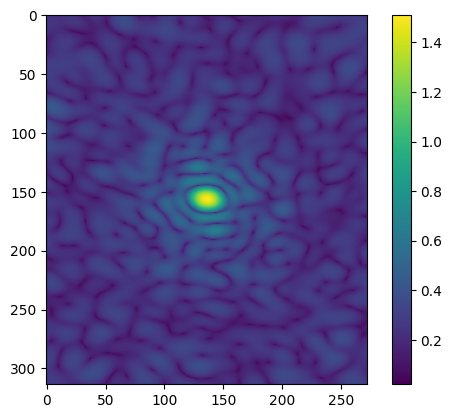

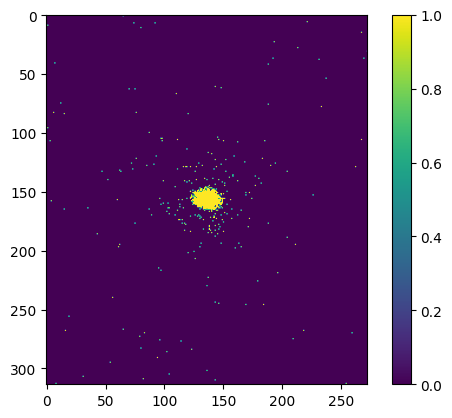

In [5]:
fn = "./SingFELPDBDiffractionCalculator/diffr_2nip.h5"
# Ideal patterns
diffr_ideal = DiffractionData.from_file(fn, SingFELFormat, "diffr_ideal", poissonize=False, index=":2")
data_dict = diffr_ideal.get_data()
img = data_dict["img_array"][0]
plt.figure()
plt.imshow(img**0.2)
plt.colorbar()
print(img.sum())

# Poissonized patterns
diffr = DiffractionData.from_file(fn, SingFELFormat, "diffr", poissonize=True, index=":")
data_dict = diffr.get_data()
img = data_dict["img_array"][0]
plt.figure()
plt.imshow(img, vmax=1)
plt.colorbar()
print(img.sum())

## Add AGIPD noise
This is described in this paper: DOI 10.1063/4.0000169

 - Parameters object -
mu                                  58.234                          The AUD/keV value of the one photon peak position, the unit needs to be consistent with that of the sigma slop and intercept. The default value is for AGIPD high-CDS mode.   
sigma_slope                         1.814                           The linear fitting slope for sigma. The unit needes to be consistent with that of the mu value. The default value is for AGIPD high-CDS mode.   
sigma_intercept                     9.041                           The linear fitting intercept for sigma. The unit needes to be consistent with that of the mu value. The default value is for AGIPD high-CDS mode.   
chunk_size                          10000                           To manipulate the data in memory in chunk.   
copy_input                          False                           If it's true, the output of this calculator a new copy from the input data will be used. File mapping input is not affecte

  0%|          | 0/5 [00:00<?, ?it/s]

Adding Gaussian Noise...


  0%|          | 0/5 [00:00<?, ?it/s]

2023-08-18 16:14:51:GaussianNoiseCalculator:INFO: Convert back to nphotons...


Operation in 1 chunks


  0%|          | 0/1 [00:00<?, ?it/s]

2023-08-18 16:14:51:GaussianNoiseCalculator:INFO: Get round values...


  0%|          | 0/1 [00:00<?, ?it/s]

Data collection:
key - mapping

diffr_GaussianNoise - <class 'dict'>: dict_keys(['img_array', 'quaternions', 'geom', 'distance', 'pixel_mask', 'beam'])

1480


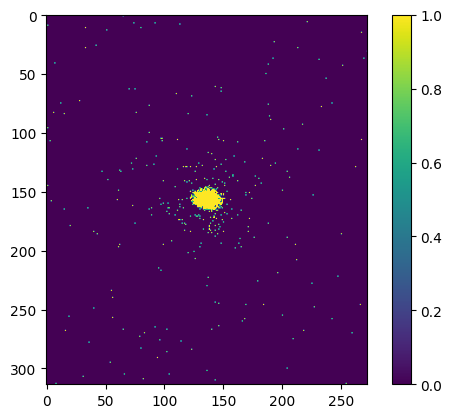

In [6]:
calc = GaussianNoiseCalculator(name="Gaussian", input=diffr)
print(calc.parameters)
out_data_collection = calc.backengine()
print(out_data_collection)
out_data = out_data_collection["diffr_GaussianNoise"]
data_dict = out_data.get_data()
img_gaussian = data_dict["img_array"][0]
plt.figure()
plt.imshow(img_gaussian, vmax=1)
plt.colorbar()
print(img_gaussian.sum())

### Larger slop and intercept gets larger noise

 - Parameters object -
mu                                  58.234                          The AUD/keV value of the one photon peak position, the unit needs to be consistent with that of the sigma slop and intercept. The default value is for AGIPD high-CDS mode.   
sigma_slope                         1.814                           The linear fitting slope for sigma. The unit needes to be consistent with that of the mu value. The default value is for AGIPD high-CDS mode.   
sigma_intercept                     15                              The linear fitting intercept for sigma. The unit needes to be consistent with that of the mu value. The default value is for AGIPD high-CDS mode.   
chunk_size                          10000                           To manipulate the data in memory in chunk.   
copy_input                          False                           If it's true, the output of this calculator a new copy from the input data will be used. File mapping input is not affecte

  0%|          | 0/5 [00:00<?, ?it/s]

Adding Gaussian Noise...


  0%|          | 0/5 [00:00<?, ?it/s]

2023-08-18 16:14:51:GaussianNoiseCalculator:INFO: Convert back to nphotons...


Operation in 1 chunks


  0%|          | 0/1 [00:00<?, ?it/s]

2023-08-18 16:14:51:GaussianNoiseCalculator:INFO: Get round values...


  0%|          | 0/1 [00:00<?, ?it/s]

3559


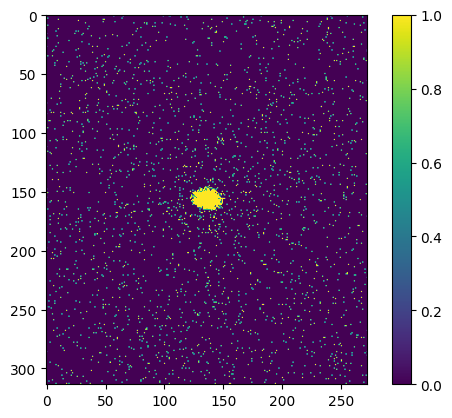

In [7]:
calc = GaussianNoiseCalculator(name="Gaussian", input=diffr)
calc.parameters["sigma_intercept"] = 15
print(calc.parameters)
test_collection = calc.backengine()
img_test = test_collection.get_data()["img_array"][0]
plt.figure()
plt.imshow(img_test, vmax=1)
plt.colorbar()
print(img_test.sum())

## Apply real detector geometry

<Axes: title={'center': 'AGIPD-1M detector geometry (agipd_simple_2d.geom)'}, xlabel='pixels', ylabel='pixels'>

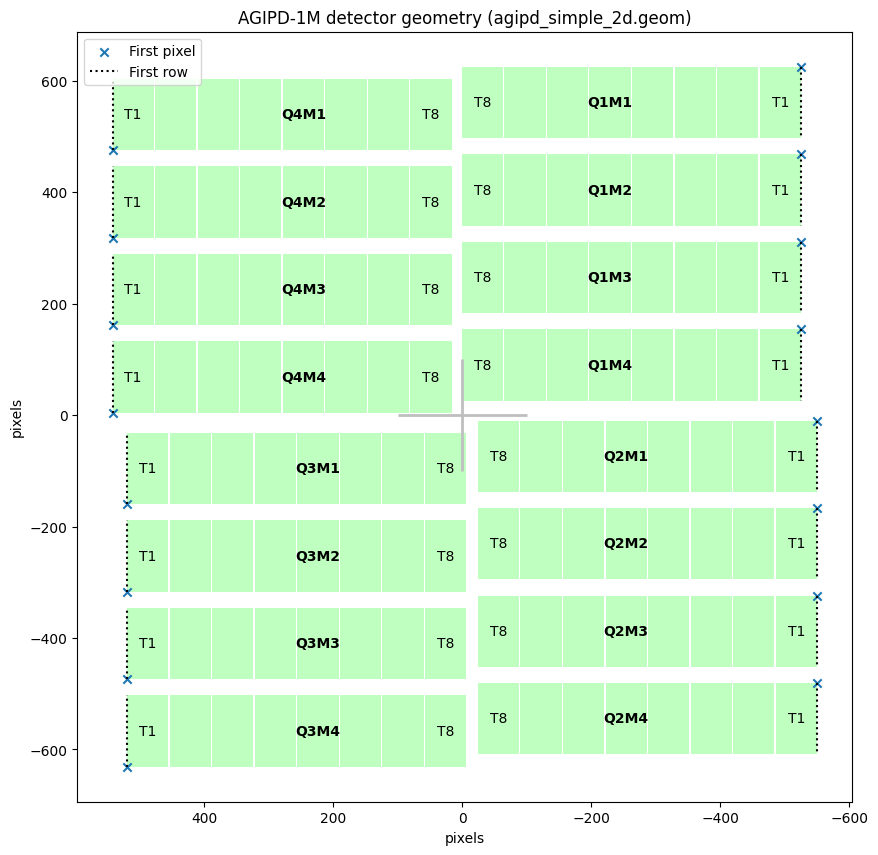

In [8]:
geom_fn = "agipd_simple_2d.geom"
geom = AGIPD_1MGeometry.from_crystfel_geom(geom_fn)
geom.inspect()

### The gaps are masked out with value -1

Applying the mask...


  0%|          | 0/5 [00:00<?, ?it/s]

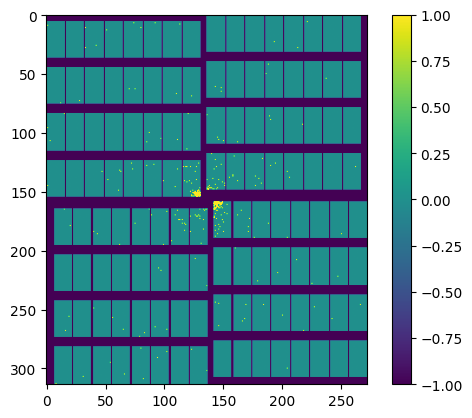

In [9]:
# Take the data with default AGIPD noise
out_data = out_data_collection.to_list()[0]
mask = out_data.apply_geom_mask(geom)
out_data_dict = out_data.get_data()
plt.imshow(out_data_dict["img_array"][0], vmax=1,vmin=-1)
plt.colorbar()

## Save the data in HDF5

In [10]:
with h5py.File("diffr.h5", "w") as h5:
    h5["data"] = out_data_dict["img_array"]